In [1]:
# Import the dependacies 
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read cleaned CSV file as a dataframe
dw_csv_df = pd.read_csv("../Resources/dropped_water.csv")

dw_csv_df.head()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0
1,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0
2,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0
3,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0
4,5.584087,188.313324,28748.687739,7.544869,280.467916,8.399735,54.917862,2.559708,0


In [3]:
# Connect to SQLite database 
conn = sqlite3.connect('dropped_water.db')

# Write DataFrame to SQLite database
dw_csv_df.to_sql('dropped_water_data', conn, if_exists='replace')

# Commit changes and close connection
conn.commit()
conn.close()

In [4]:
# Connect to the 'dropped_water.db' SQLite database
conn = sqlite3.connect('dropped_water.db')

# Read data from SQLite into a Pandas DataFrame
dw_sql_df = pd.read_sql_query("SELECT * FROM dropped_water_data", conn)

# Close the connection
conn.close()

# Display the DataFrame
dw_sql_df.head()

,index,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0
1,1,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0
2,2,8.316766,214.373394,22018.417441,8.059332,363.266516,18.436524,100.341674,4.628771,0
3,3,9.092223,181.101509,17978.986339,6.546600,398.410813,11.558279,31.997993,4.075075,0
4,4,5.584087,188.313324,28748.687739,7.544869,280.467916,8.399735,54.917862,2.559708,0


In [5]:
# Create X and y variables from the DataFrame
y= dw_sql_df["Potability"]
X= dw_sql_df.drop(columns="Potability")

In [6]:
# Check balance of values
y.value_counts()

Potability
0    1597
1    1052
Name: count, dtype: int64

In [7]:
# Split the dataset into training and testing sets
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
# Use the RandomOverSampler function to rebalance values
random_over_sampler = RandomOverSampler(random_state=1)
X_train_bal, y_train_bal = random_over_sampler.fit_resample(X_train_imb, y_train_imb)

In [9]:
# Check that rebalance was succesful
y_train_bal.value_counts()

Potability
0    1186
1    1186
Name: count, dtype: int64

In [10]:
# Random Forest classifiers for each model
rf_classifier_imb = RandomForestClassifier(random_state=1)
rf_classifier_bal = RandomForestClassifier(random_state=1)

In [11]:
# Defined a grid of hyperparameters for Random Forest classifier tuning
PARAM_GRID = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [12]:
# Setup GridSearchCV
grid_search_imb = GridSearchCV(estimator=rf_classifier_imb, param_grid=PARAM_GRID, cv=5, scoring='accuracy', n_jobs=-1)

# Setup GridSearchCV
grid_search_bal = GridSearchCV(estimator=rf_classifier_bal, param_grid=PARAM_GRID, cv=5, scoring='accuracy', n_jobs=-1)

In [13]:
# Fit GridSearchCV to the imbalanced training data
grid_search_imb.fit(X_train_imb, y_train_imb)



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [14]:
# Fit GridSearchCV to the resampled training data
grid_search_bal.fit(X_train_bal, y_train_bal)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [15]:
# Make predictions on the test set for imbalanced model
y_pred_imb = grid_search_imb.predict(X_test)

# Calculate accuracy for imbalanced model
accuracy_imb = accuracy_score(y_test, y_pred_imb)

# Calculate balanced accuracy for imbalanced model
balanced_accuracy_imb = balanced_accuracy_score(y_test, y_pred_imb)

In [16]:
print("Accuracy for imbalanced model:", accuracy_imb)
print("Balanced Accuracy for imbalanced model:", balanced_accuracy_imb)

Accuracy for imbalanced model: 0.8838612368024132
Balanced Accuracy for imbalanced model: 0.8625738616614529


In [17]:
# Make predictions on the test set for balanced model
y_pred_bal = grid_search_bal.predict(X_test)

# Calculate accuracy for balanced model
accuracy_bal = accuracy_score(y_test, y_pred_bal)

# Calculate balanced accuracy for balanced model
balanced_accuracy_bal = balanced_accuracy_score(y_test, y_pred_bal)

In [18]:
print("\nAccuracy for balanced model:", accuracy_bal)
print("Balanced Accuracy for balanced model:", balanced_accuracy_bal)


Accuracy for balanced model: 0.9079939668174962
Balanced Accuracy for balanced model: 0.8943198934074846


In [19]:
# Generate confusion matrix for imbalanced model
conf_matrix_imb = confusion_matrix(y_test, y_pred_imb)

In [20]:
# Generate confusion matrix for balanced model
conf_matrix_bal = confusion_matrix(y_test, y_pred_bal)

In [21]:
# Print confusion matrices
print("Confusion Matrix for imbalanced model:")
print(conf_matrix_imb)
print("\nClassification Report for imbalanced model:")
print(classification_report(y_test, y_pred_imb))

Confusion Matrix for imbalanced model:
[[391  20]
 [ 57 195]]

Classification Report for imbalanced model:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       411
           1       0.91      0.77      0.84       252

    accuracy                           0.88       663
   macro avg       0.89      0.86      0.87       663
weighted avg       0.89      0.88      0.88       663



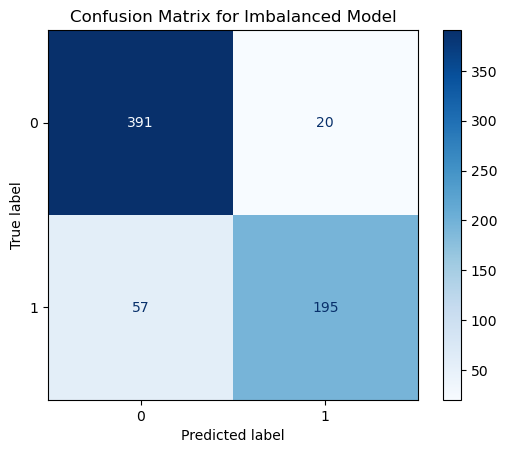

In [22]:
# Plot confusion matrix for imbalanced model
disp_imb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_imb, display_labels=grid_search_imb.best_estimator_.classes_)
disp_imb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Imbalanced Model")
plt.show()

In [23]:
# Print classification reports
print("\nConfusion Matrix for balanced model:")
print(conf_matrix_bal)
print("\nClassification Report for balanced model:")
print(classification_report(y_test, y_pred_bal))


Confusion Matrix for balanced model:
[[391  20]
 [ 41 211]]

Classification Report for balanced model:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       411
           1       0.91      0.84      0.87       252

    accuracy                           0.91       663
   macro avg       0.91      0.89      0.90       663
weighted avg       0.91      0.91      0.91       663



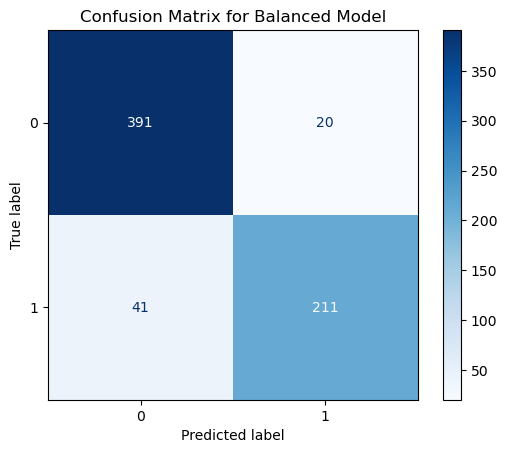

In [24]:
# Plot confusion matrix for balanced model
disp_bal = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bal, display_labels=grid_search_bal.best_estimator_.classes_)
disp_bal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Balanced Model")
plt.show()

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


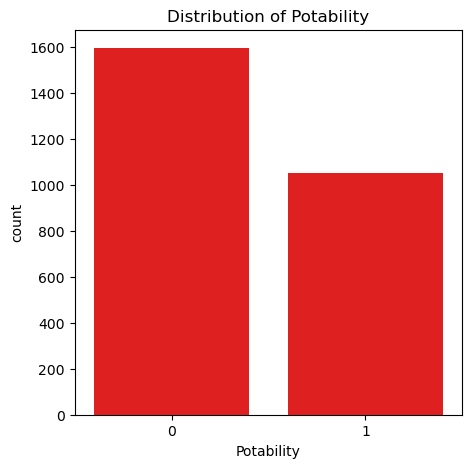

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

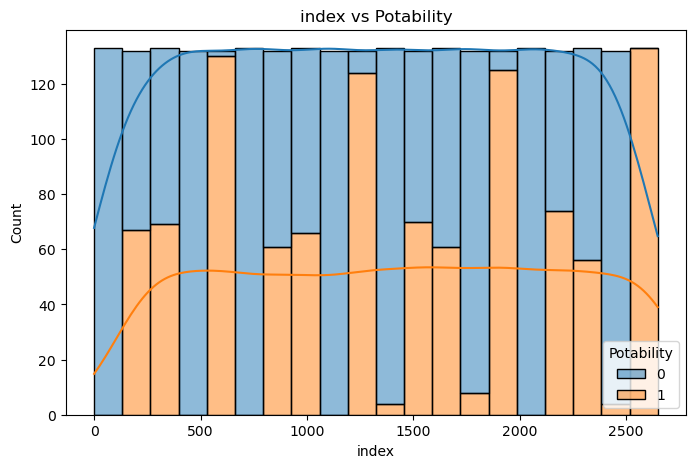

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

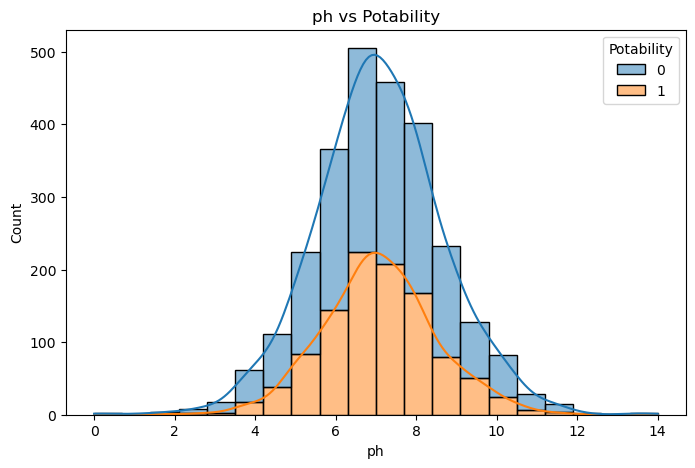

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

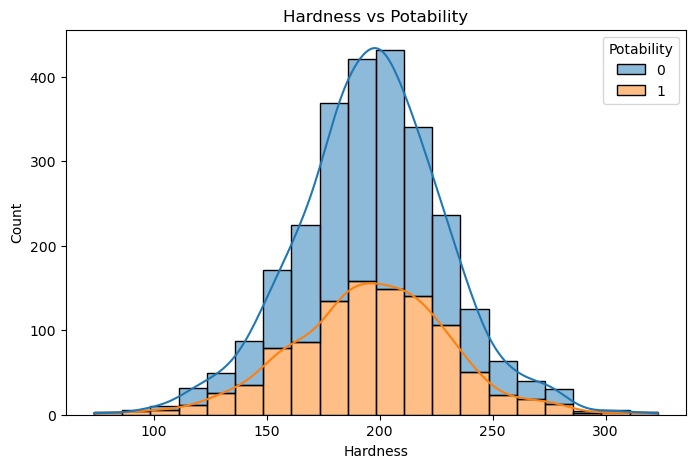

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

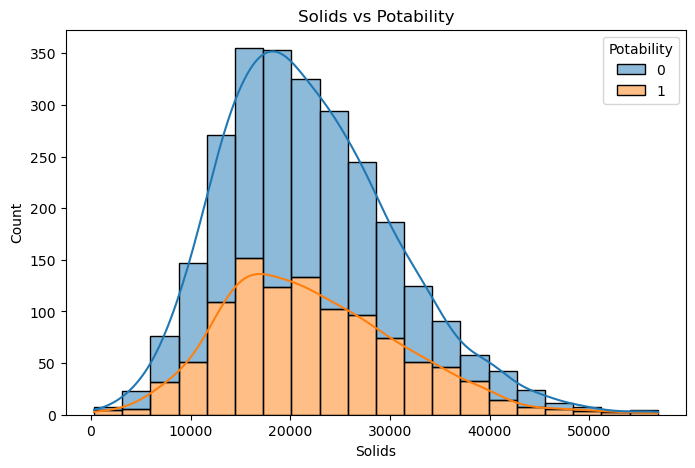

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

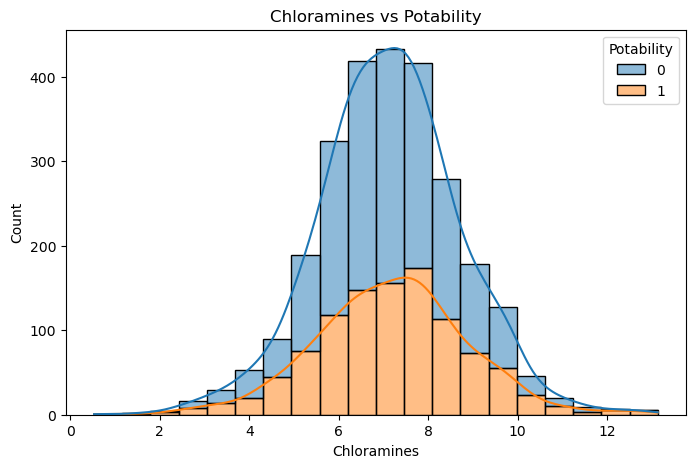

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

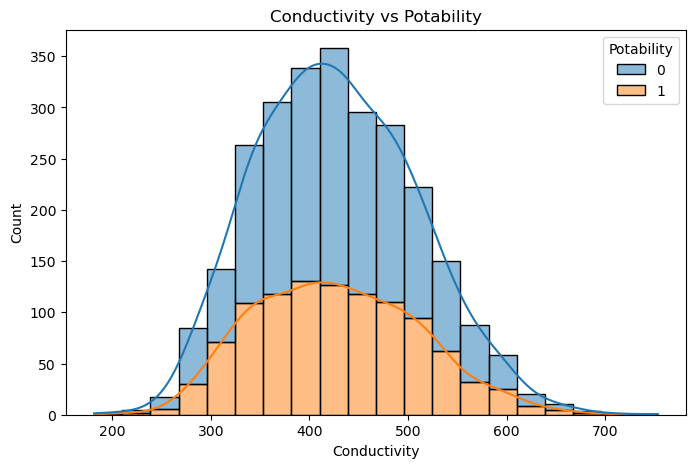

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

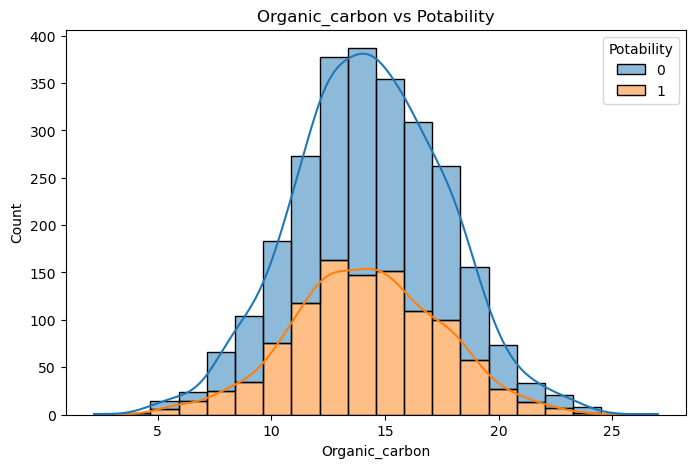

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

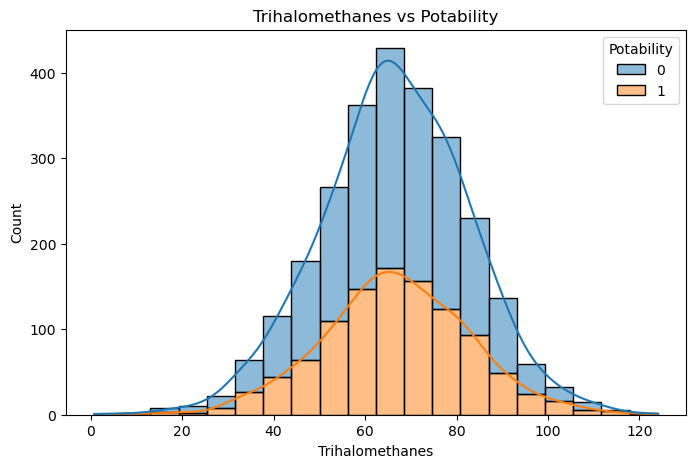

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

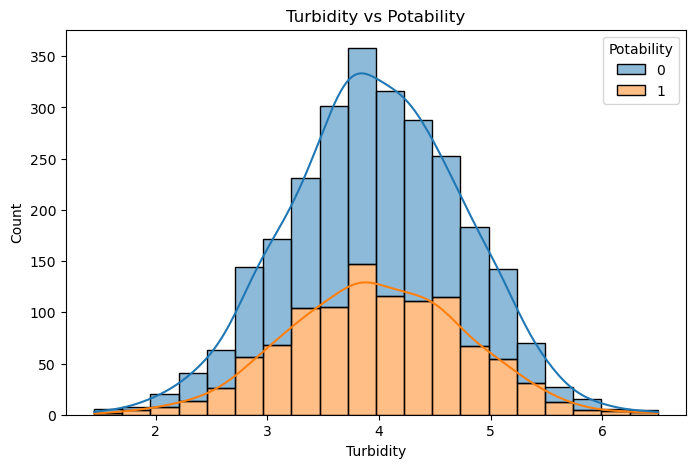

In [28]:
# Univariate Analysis
plt.figure(figsize=(5, 5))
sns.countplot(data=dw_sql_df, x=dw_sql_df["Potability"], color="red")
plt.title("Distribution of Potability")
plt.show()

for column in dw_sql_df.columns[:-1]:  # Excluding the target variable Potability
    plt.figure(figsize=(8, 5))
    sns.histplot(data=dw_sql_df, x=column, hue="Potability", kde=True, color="red", multiple="stack", bins=20)
    plt.title(f"{column} vs Potability")
    plt.show()



C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


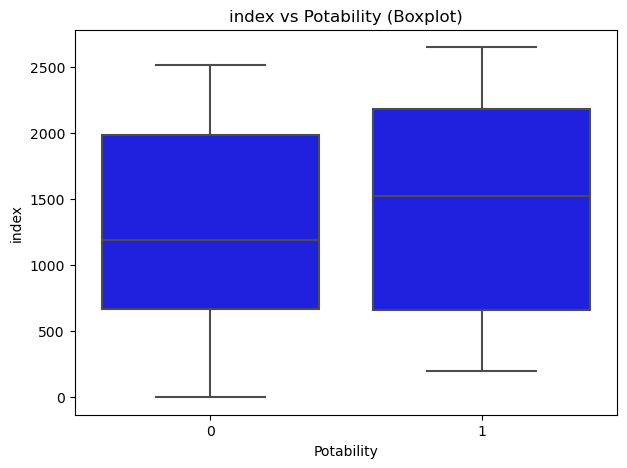

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


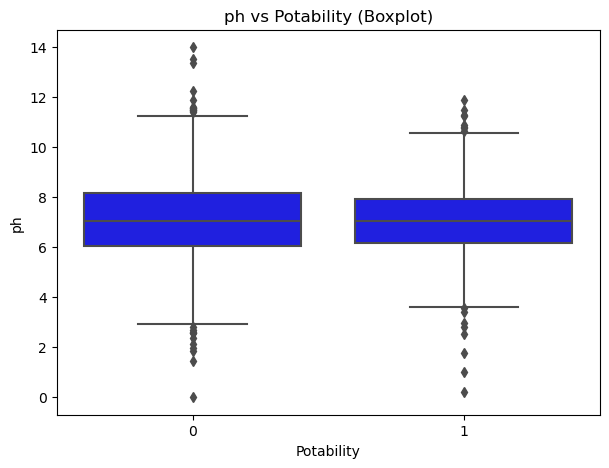

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


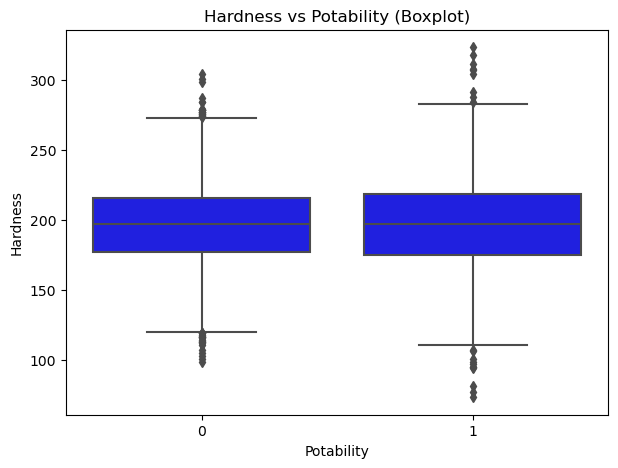

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


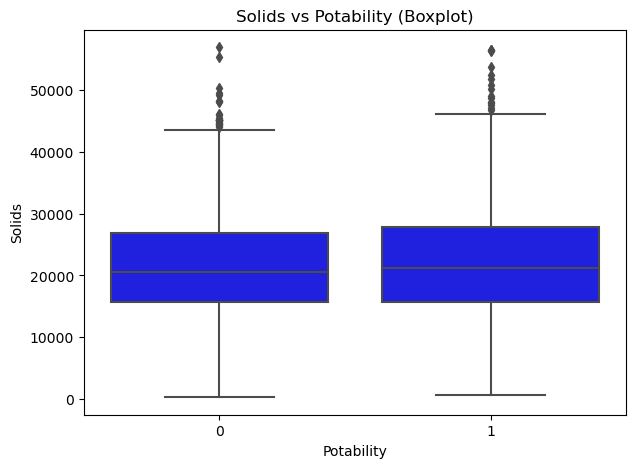

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


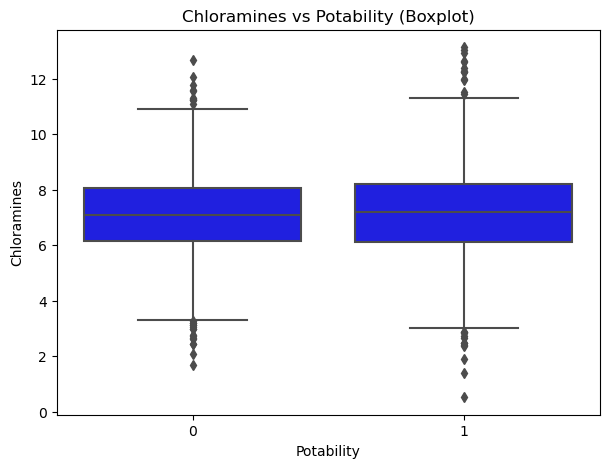

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


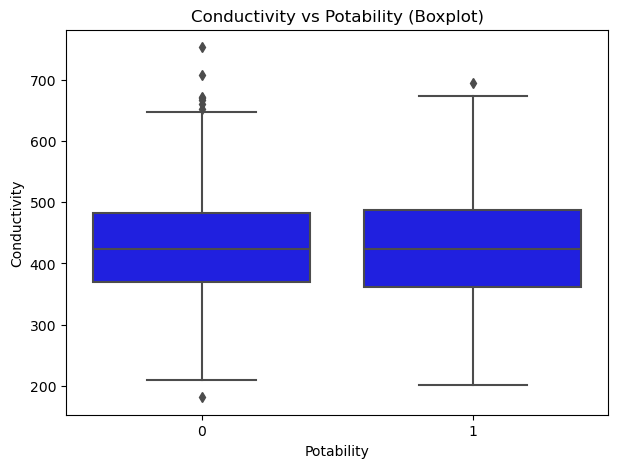

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


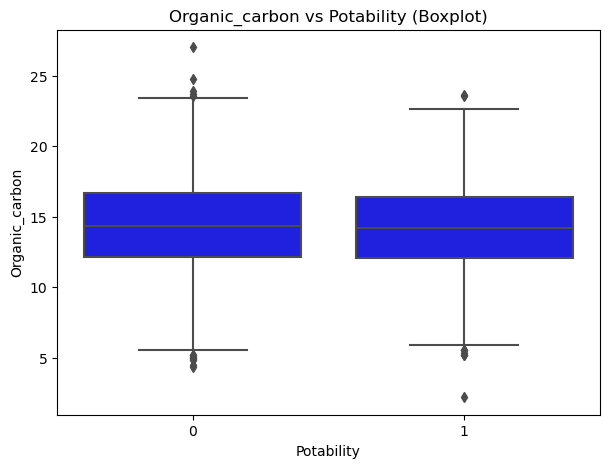

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


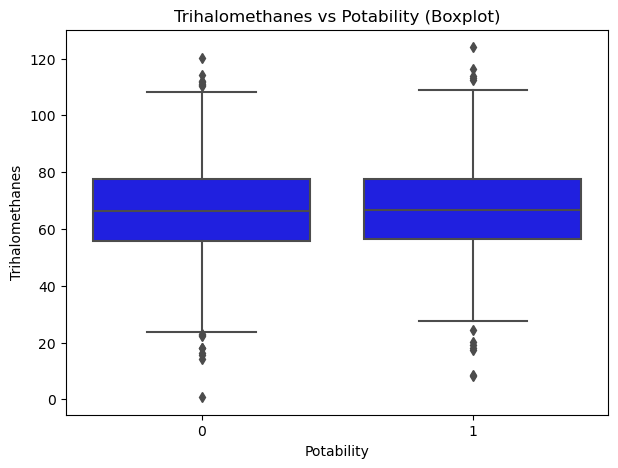

C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\maria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


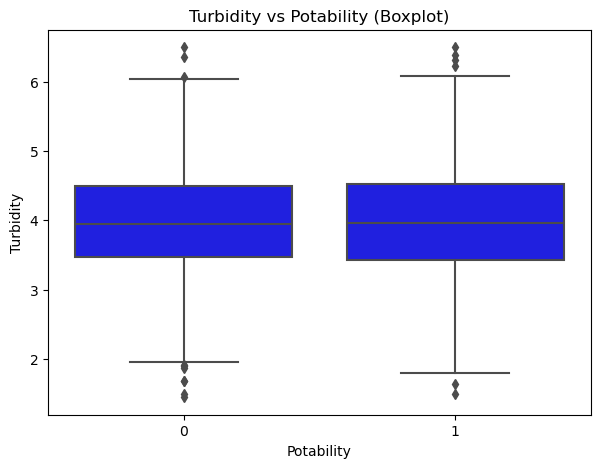

In [29]:
# Bivariate Analysis
for column in dw_sql_df.columns[:-1]:  # Excluding the target variable Potability
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=dw_sql_df, x=dw_sql_df["Potability"], y=dw_sql_df[column], color="blue")
    plt.title(f"{column} vs Potability (Boxplot)")
    plt.show()
